In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
companies_selected = pd.read_excel("Companies.xlsx")

In [40]:
companies_selected.shape

(79, 5)

In [41]:
companies_selected.head()

,Company Name,Industry,Beta Value,Grade,TSR
0,NextEra Energy (NEE),Utilities,0.49,B,53.47
1,Duke Energy (DUK),Utilities,0.38,C,57.51
2,Atmos Energy (ATO),Utilities,0.50,B,54.13
3,Avangrid (AGR),Utilities,0.34,A,-8.57
4,Otter Tail (OTTR),Utilities,0.69,A,87.72


In [42]:
# since TSR is in % we will grade wight in % as well
grade_weight = {"A": 90, "B": 80, "C": 70, "D": 60, "E": 50, "F": 40}
companies_selected["GradeWeight"] = companies_selected["Grade"].map(grade_weight)

In [43]:
def calculate_grade_score(data, x):
    return (1 - x) * data["TSR"] + x * data["GradeWeight"]

In [44]:
def monte_carlo_simulation(
    data, max_industry_allocation=0.16, max_stock_allocation=0.045, target_beta=1.0
):
    best_portfolio = None
    best_portfolio_beta = float("inf")
    best_run = None

    for iteration in range(
        65000, 80000
    ):  # We want to keep the grade wight at a minumum of 0.65 of the total caluclation
        weight_factor = iteration / 100000  # Fraction for Grade Score calculation

        # Normalize TSR:
        data["Industry TSR total"] = data.groupby("Industry")["TSR"].transform("sum")
        data["Weighted TSR"] = data["TSR"] / data["Industry TSR total"]

        # Calculate Grade Score:
        data["Grade Score"] = data.apply(
            calculate_grade_score, axis=1, args=(weight_factor,)
        )

        # Calculate Weight:
        data["Weight"] = data["Grade Score"] / data["Grade Score"].sum()

        # Apply industry-level restrictions:
        data["Industry Allocation"] = data.groupby("Industry")["Weight"].transform(
            "sum"
        )
        data["Allocation_by_restriction"] = np.where(
            data["Industry Allocation"] > max_industry_allocation,
            max_industry_allocation,
            data["Industry Allocation"],
        )

        # Normalize Weights based on restrictions:
        data["Normalised Weight"] = np.where(
            data["Allocation_by_restriction"] == max_industry_allocation,
            (data["Weight"] / data["Industry Allocation"]) * max_industry_allocation,
            data["Weight"],
        )

        # Calculate Portfolio Beta:
        portfolio_beta = (data["Beta Value"] * data["Normalised Weight"]).sum()

        # Check if this portfolio is better:
        if portfolio_beta < best_portfolio_beta:
            test = weight_factor
            best_portfolio_beta = portfolio_beta
            best_run = iteration
            best_portfolio = data.copy()
            print(best_run, best_portfolio_beta)

    return test, best_run, best_portfolio_beta, best_portfolio

In [45]:
test, run_no, final_beta, ideal_portfolio = monte_carlo_simulation(companies_selected)

65000 0.8960902104464805


In [46]:
final_beta

0.8960902104464805

In [47]:
ideal_portfolio

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight
0,NextEra Energy (NEE),Utilities,0.49,B,53.47,80,358.64,0.149091,70.7145,0.008818,0.081304,0.081304,0.008818
1,Duke Energy (DUK),Utilities,0.38,C,57.51,70,358.64,0.160356,65.6285,0.008184,0.081304,0.081304,0.008184
2,Atmos Energy (ATO),Utilities,0.50,B,54.13,80,358.64,0.150931,70.9455,0.008847,0.081304,0.081304,0.008847
3,Avangrid (AGR),Utilities,0.34,A,-8.57,90,358.64,-0.023896,55.5005,0.006921,0.081304,0.081304,0.006921
4,Otter Tail (OTTR),Utilities,0.69,A,87.72,90,358.64,0.244591,89.2020,0.011123,0.081304,0.081304,0.011123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,COSTCO WHOLESALE CORPORATION (XNAS:COST),Consumer Staples,0.79,D,222.00,60,694.10,0.319839,116.7000,0.014552,0.095134,0.095134,0.014552
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,-51.22,80,694.10,-0.073793,34.0730,0.004249,0.095134,0.095134,0.004249
76,COLGATE-PALMOLIVE COMPANY (XNYS:CL),Consumer Staples,0.41,A,59.00,90,694.10,0.085002,79.1500,0.009870,0.095134,0.095134,0.009870
77,THE HERSHEY COMPANY (XNYS:HSY),Consumer Staples,0.37,B,38.00,80,694.10,0.054747,65.3000,0.008143,0.095134,0.095134,0.008143


In [48]:
ideal_portfolio.groupby("Industry")["Allocation_by_restriction"].mean()

Industry
Consumer Staples    0.095134
Energy              0.109765
Finance             0.129784
Healthcare          0.127471
Industruals         0.109167
Real Estate         0.078241
Technology          0.160000
Utilities           0.081304
Name: Allocation_by_restriction, dtype: float64

In [49]:
0.077816 + 0.117657 + 0.139116 + 0.136636 + 0.069275 + 0.083867 + 0.160000 + 0.087150

0.8715170000000001

In [50]:
left_over = 1 - ideal_portfolio["Normalised Weight"].sum()
left_over

0.10913266324038762

In [51]:
no_change = len(ideal_portfolio[ideal_portfolio["Allocation_by_restriction"] >= 0.16])

In [52]:
change = len(ideal_portfolio)

In [53]:
addition = left_over / (change - no_change)

In [54]:
addition

0.0015590380462912517

In [55]:
(ideal_portfolio["Allocation_by_restriction"] > 0.1599).sum()

9

In [56]:
ideal_portfolio["final_weight"] = np.where(
    ideal_portfolio["Allocation_by_restriction"] >= 0.1600,
    ideal_portfolio["Normalised Weight"],
    ideal_portfolio["Normalised Weight"] + addition,
)

In [57]:
ideal_portfolio["final_weight"].sum()

1.0

In [58]:
ideal_portfolio.groupby("Industry")["final_weight"].sum()

Industry
Consumer Staples    0.110724
Energy              0.125356
Finance             0.145375
Healthcare          0.143061
Industruals         0.124758
Real Estate         0.093832
Technology          0.160000
Utilities           0.096894
Name: final_weight, dtype: float64

In [59]:
a = ideal_portfolio

In [60]:
# -------------------------------------------------------------- for capping stocks at 4.5%

In [61]:
ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["final_weight"], 4.5)

In [62]:
ideal_portfolio.sort_values("final_weight", ascending=False)[
    ["Company Name", "final_weight"]
]

,Company Name,final_weight
44,NVDA,0.073294
25,Eli Lilly and Company (LLY),0.036699
40,TSLA,0.036409
10,Interactive Brokers (IBKR),0.019668
11,LPL Financial (LPLA),0.019320
...,...,...
51,EQR,0.007350
57,PEAK,0.007050
75,DOLLAR GENERAL CORPORATION (XNYS:DG),0.005808
48,COIN,0.003581


In [63]:
ideal_portfolio["Capped_weight"] = np.minimum(ideal_portfolio["final_weight"], 0.045)

In [64]:
ideal_portfolio.sort_values("Capped_weight", ascending=False)[
    ["Company Name", "Capped_weight"]
]

,Company Name,Capped_weight
44,NVDA,0.045000
25,Eli Lilly and Company (LLY),0.036699
40,TSLA,0.036409
10,Interactive Brokers (IBKR),0.019668
11,LPL Financial (LPLA),0.019320
...,...,...
51,EQR,0.007350
57,PEAK,0.007050
75,DOLLAR GENERAL CORPORATION (XNYS:DG),0.005808
48,COIN,0.003581


In [65]:
while True:
    industry_totals = ideal_portfolio.groupby("Industry")["final_weight"].transform(
        "sum"
    )
    capped_totals = ideal_portfolio.groupby("Industry")["Capped_weight"].transform(
        "sum"
    )
    excess_weight = industry_totals - capped_totals

    if (excess_weight <= 0).all():
        break

    # Identify eligible stocks (below cap) for redistribution
    eligible = ideal_portfolio["Capped_weight"] < 0.045
    eligible_totals = (
        ideal_portfolio[eligible].groupby("Industry")["Capped_weight"].transform("sum")
    )

    # Redistribute proportionally among eligible stocks
    redistribution = (
        ideal_portfolio["Capped_weight"] / eligible_totals
    ) * excess_weight
    redistribution = redistribution.fillna(
        0
    )  # Avoid NaN for industries with no eligible stocks
    ideal_portfolio.loc[eligible, "Capped_weight"] += redistribution[eligible]

    # Reapply the cap
    ideal_portfolio["Capped_weight"] = np.minimum(
        ideal_portfolio["Capped_weight"], 0.045
    )

In [66]:
ideal_portfolio["Capped_weight"] *= 100

### VERIFY PORTFOLIO CONSTRATINTS -

In [67]:
round(ideal_portfolio["Capped_weight"].sum(), 2) == 100.00

True

In [68]:
ideal_portfolio.sort_values(by="Capped_weight", ascending=False)

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight,final_weight,Capped_weight
44,NVDA,Technology,1.76,C,2694.86,70,4829.52,0.557997,988.7010,0.123286,0.269133,0.160000,0.073294,0.073294,4.500000
40,TSLA,Technology,2.12,A,1236.11,90,4829.52,0.255949,491.1385,0.061242,0.269133,0.160000,0.036409,0.036409,4.500000
25,Eli Lilly and Company (LLY),Healthcare,0.42,C,675.16,70,1435.04,0.470482,281.8060,0.035140,0.127471,0.127471,0.035140,0.036699,3.669877
10,Interactive Brokers (IBKR),Finance,0.79,D,303.51,60,1525.19,0.198998,145.2285,0.018109,0.129784,0.129784,0.018109,0.019668,1.966827
11,LPL Financial (LPLA),Finance,0.85,C,276.95,70,1525.19,0.181584,142.4325,0.017761,0.129784,0.129784,0.017761,0.019320,1.931962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,EQR,Real Estate,0.85,C,2.70,70,307.04,0.008794,46.4450,0.005791,0.078241,0.078241,0.005791,0.007350,0.735049
57,PEAK,Real Estate,0.75,B,-22.76,80,307.04,-0.074127,44.0340,0.005491,0.078241,0.078241,0.005491,0.007050,0.704985
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,-51.22,80,694.10,-0.073793,34.0730,0.004249,0.095134,0.095134,0.004249,0.005808,0.580776
48,COIN,Technology,3.34,B,-10.57,80,4829.52,-0.002189,48.3005,0.006023,0.269133,0.160000,0.003581,0.003581,0.498316


In [69]:
ideal_portfolio

,Company Name,Industry,Beta Value,Grade,TSR,GradeWeight,Industry TSR total,Weighted TSR,Grade Score,Weight,Industry Allocation,Allocation_by_restriction,Normalised Weight,final_weight,Capped_weight
0,NextEra Energy (NEE),Utilities,0.49,B,53.47,80,358.64,0.149091,70.7145,0.008818,0.081304,0.081304,0.008818,0.010377,1.037676
1,Duke Energy (DUK),Utilities,0.38,C,57.51,70,358.64,0.160356,65.6285,0.008184,0.081304,0.081304,0.008184,0.009743,0.974257
2,Atmos Energy (ATO),Utilities,0.50,B,54.13,80,358.64,0.150931,70.9455,0.008847,0.081304,0.081304,0.008847,0.010406,1.040557
3,Avangrid (AGR),Utilities,0.34,A,-8.57,90,358.64,-0.023896,55.5005,0.006921,0.081304,0.081304,0.006921,0.008480,0.847966
4,Otter Tail (OTTR),Utilities,0.69,A,87.72,90,358.64,0.244591,89.2020,0.011123,0.081304,0.081304,0.011123,0.012682,1.268206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,COSTCO WHOLESALE CORPORATION (XNAS:COST),Consumer Staples,0.79,D,222.00,60,694.10,0.319839,116.7000,0.014552,0.095134,0.095134,0.014552,0.016111,1.611092
75,DOLLAR GENERAL CORPORATION (XNYS:DG),Consumer Staples,0.45,B,-51.22,80,694.10,-0.073793,34.0730,0.004249,0.095134,0.095134,0.004249,0.005808,0.580776
76,COLGATE-PALMOLIVE COMPANY (XNYS:CL),Consumer Staples,0.41,A,59.00,90,694.10,0.085002,79.1500,0.009870,0.095134,0.095134,0.009870,0.011429,1.142863
77,THE HERSHEY COMPANY (XNYS:HSY),Consumer Staples,0.37,B,38.00,80,694.10,0.054747,65.3000,0.008143,0.095134,0.095134,0.008143,0.009702,0.970161


In [70]:
a = ideal_portfolio.groupby("Industry")["final_weight"].sum()
a

Industry
Consumer Staples    0.110724
Energy              0.125356
Finance             0.145375
Healthcare          0.143061
Industruals         0.124758
Real Estate         0.093832
Technology          0.160000
Utilities           0.096894
Name: final_weight, dtype: float64

In [71]:
# ---------------------------------------------------------------------- EVERYTHING BELOW IS FOR TESTING OUT PORTFOLIO

In [72]:
final_port = ideal_portfolio[["Company Name", "Capped_weight"]]
ticker_map = pd.read_excel("ticker_map.xlsx")
mapping_dict = dict(zip(ticker_map["Company Name"], ticker_map["Ticker"]))
final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)

final_port = final_port.set_index("Ticker")
final_port

C:\Users\asus\AppData\Local\Temp\ipykernel_26580\3355036518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_port["Ticker"] = final_port["Company Name"].map(mapping_dict)


,Company Name,Capped_weight
Ticker,,
NEE,NextEra Energy (NEE),1.037676
DUK,Duke Energy (DUK),0.974257
ATO,Atmos Energy (ATO),1.040557
AGR,Avangrid (AGR),0.847966
OTTR,Otter Tail (OTTR),1.268206
...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863


In [84]:
start_date = pd.to_datetime("12-04-2024")

# Generate the previous 30 days, starting from today
dates = pd.date_range(
    start=start_date - pd.Timedelta(days=30), end=start_date, freq="D"
)

# Create a DataFrame with 30 empty columns (NaN values) for each of the previous 30 days
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

,Company Name,Capped_weight,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DUK,Duke Energy (DUK),0.974257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,Atmos Energy (ATO),1.040557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGR,Avangrid (AGR),0.847966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTTR,Otter Tail (OTTR),1.268206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
### USE THISS

import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


def get_returns(ticker, checkdate, intvl, start_of_year, mth, dys):
    # Calculate the start of the year for the given date
    try:
        # start_of_year = "2024-01-01"

        checkdate = checkdate + relativedelta(months=mth, days=dys)

        # Fetch data using yfinance
        data = yf.download(ticker, start=start_of_year, end=checkdate, interval=intvl)

        # Get the adjusted close price on the first day of the year
        start_price = data["Adj Close"].iloc[0]  # Price on the start of the year

        # Calculate the return as the percentage change from the start of the year
        current_price = data["Adj Close"].iloc[-1]  # Price on the current date

        pct_change = ((current_price / start_price) - 1) * 100  # Percentage change

        return pct_change

    except Exception as e:
        # Catch the specific error for failed downloads
        print(f"Failed to download data for {ticker}: {e}")
        return None


for indx in df_updated.index:
    for months in df_updated.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object

        # Update your DataFrame with the calculated return
        if indx == "PKST":
            break
        else:
            df_updated.at[indx, months] = get_returns(
                indx,
                month,
                intvl="1d",
                start_of_year=pd.to_datetime("12-05-2024") - timedelta(days=30),
                mth=0,
                dys=1,
            ).values[0]

a = df_updated
df_updated

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Company Name,Capped_weight,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,0.0,-5.251116,-5.123960,-2.136045,-2.136045,-2.136045,-3.483785,...,-1.902573,-0.814595,0.503780,0.503780,0.695778,0.695778,0.695778,-1.352183,-2.350563,-3.054554
DUK,Duke Energy (DUK),0.974257,NaN,0.0,-0.394463,-2.629731,-0.745089,-0.745089,-0.745089,-1.420057,...,1.767301,3.572565,3.908837,3.908837,3.581416,3.581416,3.581416,1.926589,0.563791,0.245215
ATO,Atmos Energy (ATO),1.040557,NaN,0.0,0.652275,2.507623,4.500665,4.500665,4.500665,5.892165,...,9.476613,9.585965,10.387824,10.387824,10.307649,10.307649,10.307649,8.295686,6.451394,4.971587
AGR,Avangrid (AGR),0.847966,NaN,0.0,-0.308205,-0.028025,0.588408,0.588408,0.588408,0.420282,...,1.288882,1.344909,1.288882,1.288882,1.148781,1.148781,1.148781,1.290602,1.177141,0.666585
OTTR,Otter Tail (OTTR),1.268206,NaN,0.0,4.868179,1.152661,-3.053347,-3.053347,-3.053347,-0.147147,...,1.072180,-1.037087,-0.235326,-0.235326,-0.531361,-0.531361,-0.531361,-0.222988,-0.408014,-1.345460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,0.0,1.020032,2.669154,6.024693,6.024693,6.024693,4.797963,...,7.944554,9.136459,8.018694,8.018694,9.179148,9.179148,9.179148,9.529643,10.332863,11.318063
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,0.0,-5.099909,-4.290793,-5.663850,-5.663850,-5.663850,-6.472967,...,-6.105190,-8.495771,-6.509743,-6.509743,-5.271550,-5.271550,-5.271550,-4.634055,-3.126153,-2.537697
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,0.0,0.172392,0.215494,1.686988,1.686988,1.686988,1.619262,...,2.401188,3.035345,2.912200,2.912200,2.924517,2.924517,2.924517,2.536630,2.899893,3.146165


In [86]:
for col in df_updated.columns[2:]:
    df_updated[col] = df_updated[col] * (df_updated["Capped_weight"])
df_updated

,Company Name,Capped_weight,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
Ticker,,,,,,,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,0.0,-5.448960,-5.317013,-2.216524,-2.216524,-2.216524,-3.615041,...,-1.974255,-0.845286,0.522761,0.522761,0.721993,0.721993,0.721993,-1.403128,-2.439124,-3.169639
DUK,Duke Energy (DUK),0.974257,NaN,0.0,-0.384309,-2.562033,-0.725908,-0.725908,-0.725908,-1.383500,...,1.721804,3.480595,3.808211,3.808211,3.489219,3.489219,3.489219,1.876992,0.549277,0.238902
ATO,Atmos Energy (ATO),1.040557,NaN,0.0,0.678729,2.609324,4.683198,4.683198,4.683198,6.131133,...,9.860955,9.974742,10.809123,10.809123,10.725695,10.725695,10.725695,8.632133,6.713043,5.173220
AGR,Avangrid (AGR),0.847966,NaN,0.0,-0.261348,-0.023764,0.498950,0.498950,0.498950,0.356385,...,1.092928,1.140437,1.092928,1.092928,0.974127,0.974127,0.974127,1.094387,0.998175,0.565241
OTTR,Otter Tail (OTTR),1.268206,NaN,0.0,6.173853,1.461811,-3.872273,-3.872273,-3.872273,-0.186613,...,1.359745,-1.315240,-0.298442,-0.298442,-0.673875,-0.673875,-0.673875,-0.282795,-0.517446,-1.706320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,0.0,1.643365,4.300252,9.706331,9.706331,9.706331,7.729957,...,12.799403,14.719672,12.918849,12.918849,14.788448,14.788448,14.788448,15.353126,16.647187,18.234435
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,0.0,-2.961906,-2.491991,-3.289430,-3.289430,-3.289430,-3.759345,...,-3.545749,-4.934142,-3.780704,-3.780704,-3.061591,-3.061591,-3.061591,-2.691349,-1.815595,-1.473834
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,0.0,0.197020,0.246281,1.927995,1.927995,1.927995,1.850594,...,2.744228,3.468983,3.328245,3.328245,3.342321,3.342321,3.342321,2.899020,3.314180,3.595634


### SECTOR PERFORMANCE -

In [89]:
df_sectors = ["SPY", "XLI", "XLP", "XLE", "XLF", "XLV", "XLRE", "XLK", "XLU"]

df_sectors = pd.DataFrame(df_sectors, index=df_sectors)

start_date = pd.to_datetime("12-04-2024")


# Generate the previous 30 days, starting from today
dates = pd.date_range(
    start=start_date - pd.Timedelta(days=30), end=start_date, freq="D"
)

# Create a DataFrame with 30 empty columns (NaN values) for each of the previous 30 days
new_columns = pd.DataFrame(
    np.nan, index=df_sectors.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_sectors = pd.concat([df_sectors, new_columns], axis=1)
df_sectors = df_sectors.drop(df_sectors.columns[0], axis=1)
df_sectors


for indx in df_sectors.index:
    for months in df_sectors.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object
        df_sectors.at[indx, months] = get_returns(
            indx,
            month,
            intvl="1d",
            start_of_year=pd.to_datetime("12-04-2024") - timedelta(days=30),
            mth=0,
            dys=1,
        ).values[0]

df_sectors

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
SPY,NaN,NaN,NaN,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,...,4.864785,5.412335,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,6.642561
XLI,NaN,NaN,NaN,5.020171,6.148211,6.148211,6.148211,6.969970,6.051103,6.275208,...,7.231430,7.358439,6.962492,6.962492,7.567612,7.567612,7.567612,6.775730,6.103390,6.566557
XLP,NaN,NaN,NaN,-0.647013,0.559907,0.559907,0.559907,0.211519,0.323497,0.622123,...,2.388949,2.811988,3.023517,3.023517,3.546097,3.546097,3.546097,3.421675,2.886649,2.600468
XLE,NaN,NaN,NaN,3.974542,4.666741,4.666741,4.666741,5.258456,4.700233,5.515242,...,6.453052,6.307917,6.196275,6.196275,6.654013,6.654013,6.654013,5.526401,5.515242,2.969748
XLF,NaN,NaN,NaN,5.337081,6.287813,6.287813,6.287813,7.800347,7.476238,7.541058,...,10.328441,10.544514,10.760587,10.760587,10.933452,10.933452,10.933452,9.831468,9.010376,8.599826
XLV,NaN,NaN,NaN,1.594329,2.323355,2.323355,2.323355,1.723785,0.306600,0.040879,...,-0.940250,-0.408807,0.122636,0.122636,0.436056,0.436056,0.436056,0.258901,0.034069,-0.020439
XLRE,NaN,NaN,NaN,-0.115694,1.596480,1.596480,1.596480,0.717255,-0.555302,0.231371,...,3.378063,3.887090,4.604345,4.604345,4.118461,4.118461,4.118461,2.545114,1.943545,1.665889
XLK,NaN,NaN,NaN,6.114236,5.998032,5.998032,5.998032,5.412533,5.546611,5.180118,...,4.402427,4.925355,3.504065,3.504065,4.465000,4.465000,4.465000,5.457223,5.837131,7.772414
XLU,NaN,NaN,NaN,0.634722,2.564771,2.564771,2.564771,2.849747,1.670986,1.489639,...,5.699484,7.383426,7.383426,7.383426,7.422284,7.422284,7.422284,5.116586,4.209845,4.196898


In [90]:
df_sectors = df_sectors.fillna(0)
df_sectors

,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,...,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04
SPY,0.0,0.0,0.0,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,...,4.864785,5.412335,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,6.642561
XLI,0.0,0.0,0.0,5.020171,6.148211,6.148211,6.148211,6.969970,6.051103,6.275208,...,7.231430,7.358439,6.962492,6.962492,7.567612,7.567612,7.567612,6.775730,6.103390,6.566557
XLP,0.0,0.0,0.0,-0.647013,0.559907,0.559907,0.559907,0.211519,0.323497,0.622123,...,2.388949,2.811988,3.023517,3.023517,3.546097,3.546097,3.546097,3.421675,2.886649,2.600468
XLE,0.0,0.0,0.0,3.974542,4.666741,4.666741,4.666741,5.258456,4.700233,5.515242,...,6.453052,6.307917,6.196275,6.196275,6.654013,6.654013,6.654013,5.526401,5.515242,2.969748
XLF,0.0,0.0,0.0,5.337081,6.287813,6.287813,6.287813,7.800347,7.476238,7.541058,...,10.328441,10.544514,10.760587,10.760587,10.933452,10.933452,10.933452,9.831468,9.010376,8.599826
XLV,0.0,0.0,0.0,1.594329,2.323355,2.323355,2.323355,1.723785,0.306600,0.040879,...,-0.940250,-0.408807,0.122636,0.122636,0.436056,0.436056,0.436056,0.258901,0.034069,-0.020439
XLRE,0.0,0.0,0.0,-0.115694,1.596480,1.596480,1.596480,0.717255,-0.555302,0.231371,...,3.378063,3.887090,4.604345,4.604345,4.118461,4.118461,4.118461,2.545114,1.943545,1.665889
XLK,0.0,0.0,0.0,6.114236,5.998032,5.998032,5.998032,5.412533,5.546611,5.180118,...,4.402427,4.925355,3.504065,3.504065,4.465000,4.465000,4.465000,5.457223,5.837131,7.772414
XLU,0.0,0.0,0.0,0.634722,2.564771,2.564771,2.564771,2.849747,1.670986,1.489639,...,5.699484,7.383426,7.383426,7.383426,7.422284,7.422284,7.422284,5.116586,4.209845,4.196898


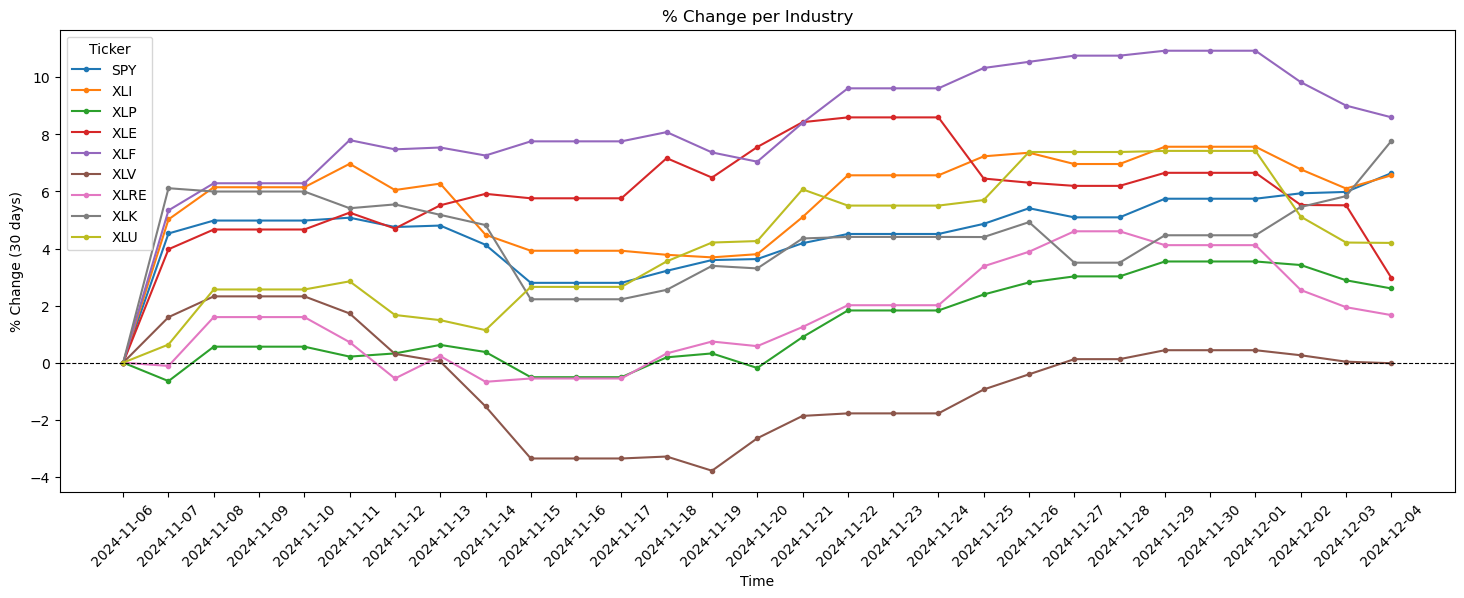

<Figure size 640x480 with 0 Axes>

In [91]:
plt.figure(figsize=(18, 6))
for ticker in df_sectors.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_sectors.columns[2:],
        df_sectors.loc[ticker].values[2:],
        label=ticker,
        marker="o",
        markersize=3,
    )

plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (30 days)")
plt.xticks(rotation=45)
plt.title("% Change per Industry")
plt.show()
plt.savefig("sector_returns")

In [92]:
sect_returns = df_sectors[1:][df_sectors.columns[-1]]
sect_returns.mean()
sect_returns

XLI     6.566557
XLP     2.600468
XLE     2.969748
XLF     8.599826
XLV    -0.020439
XLRE    1.665889
XLK     7.772414
XLU     4.196898
Name: 2024-12-04, dtype: float64

### PORTFOLIO VS SPY -

In [93]:
a = df_updated

In [94]:
# Sum the values of each column (from the 3rd column onward)
column_wavg = df_updated.iloc[:, 2:].mean(axis=0)

# Create a new DataFrame with the same columns
df_avgs = pd.DataFrame(
    column_wavg
).T  # Transpose to match the structure of the original DataFrame
df_avgs.columns = df_updated.columns[
    2:
]  # Assign the column names from the 3rd column onward

# Add the two new index values: 'portfolio name' and 'SPY'
df_avgs.index = ["portfolio"]
spy_values = [np.NAN, np.NAN, np.NAN]

# Iterate over the columns from the 3rd column onward
for months in df_updated.columns[3:]:
    if isinstance(months, str):
        month = datetime.strptime(months, "%Y-%m-%d")
    else:
        month = months  # Already a datetime object
    month = datetime.strptime(months, "%Y-%m-%d")
    spy_value = get_returns(
        "SPY",
        month,
        intvl="1d",
        start_of_year=pd.to_datetime("12-04-2024") - timedelta(days=30),
        mth=0,
        dys=1,
    ).values[0]
    spy_values.append(spy_value)

spy_values = pd.DataFrame([spy_values])
spy_values.columns = df_updated.columns
spy_values.index = ["SPY"]
df_avgs = pd.concat([df_avgs, spy_values])
df_avgs

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,...,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,Company Name,Capped_weight
portfolio,NaN,0.000000,3.998725,4.234054,5.919256,5.919256,5.919256,7.210174,5.950944,5.849599,...,8.028076,8.028076,8.724001,8.724001,8.724001,8.459807,8.198309,8.329815,NaN,NaN
SPY,NaN,1.209178,3.725800,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,...,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,6.642561,NaN,NaN


In [95]:
df_avgs = df_avgs.fillna(0)
df_avgs

,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12,2024-11-13,...,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,Company Name,Capped_weight
portfolio,0.0,0.000000,3.998725,4.234054,5.919256,5.919256,5.919256,7.210174,5.950944,5.849599,...,8.028076,8.028076,8.724001,8.724001,8.724001,8.459807,8.198309,8.329815,0.0,0.0
SPY,0.0,1.209178,3.725800,4.527823,4.980608,4.980608,4.980608,5.080643,4.754221,4.805111,...,5.092929,5.092929,5.745773,5.745773,5.745773,5.935313,5.984447,6.642561,0.0,0.0


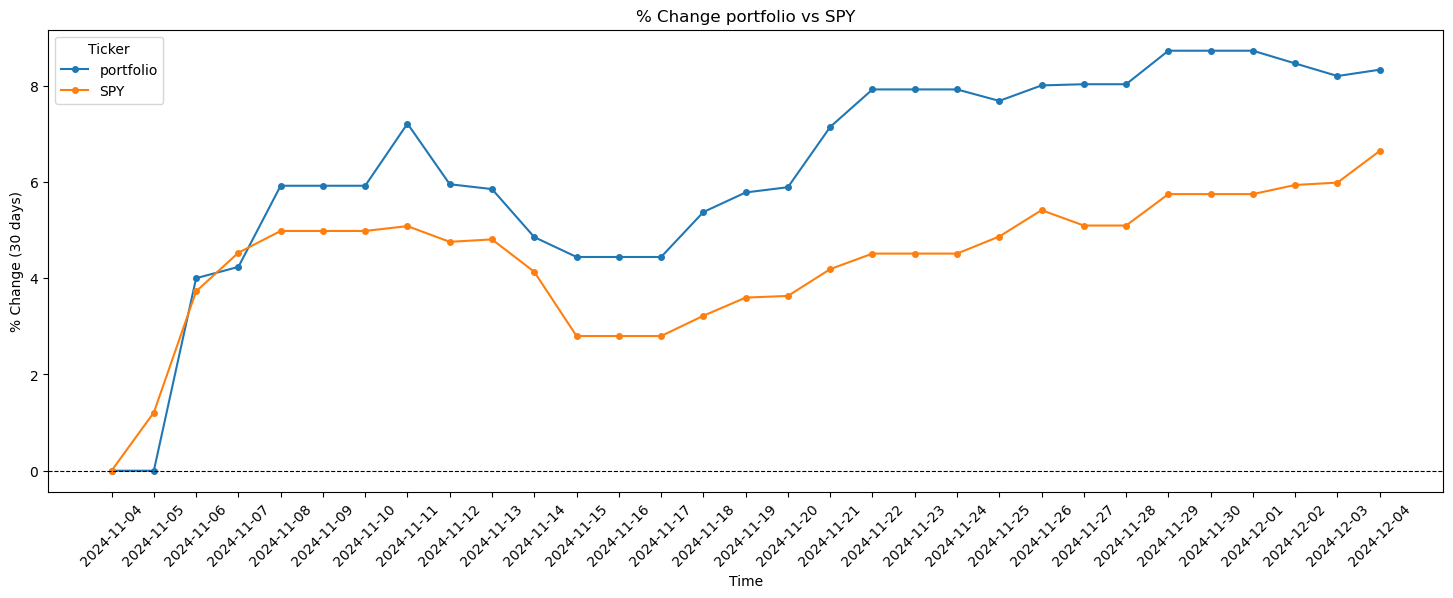

In [96]:
plt.figure(figsize=(18, 6))
for ticker in df_avgs.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_avgs.columns[:-2],
        df_avgs.loc[ticker].values[:-2],
        label=ticker,
        marker="o",
        markersize=4,
    )
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (30 days)")
plt.title("% Change portfolio vs SPY")
plt.xticks(rotation=45)
plt.show()

### YEARLY

In [97]:
df_updated = df_updated[["Company Name", "Capped_weight"]]
df_updated

,Company Name,Capped_weight
Ticker,,
NEE,NextEra Energy (NEE),1.037676
DUK,Duke Energy (DUK),0.974257
ATO,Atmos Energy (ATO),1.040557
AGR,Avangrid (AGR),0.847966
OTTR,Otter Tail (OTTR),1.268206
...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863


In [98]:
start_date = "2023-12-01"

# Generate the first day of each month, starting from the start_date to the end of 2024
dates = pd.date_range(
    start=start_date,
    end="2024-12-01",
    freq="MS",  # 'MS' specifies the first day of each month
)

# Create a DataFrame with NaN values for each of these dates
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

,Company Name,Capped_weight,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
Ticker,,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DUK,Duke Energy (DUK),0.974257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATO,Atmos Energy (ATO),1.040557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGR,Avangrid (AGR),0.847966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTTR,Otter Tail (OTTR),1.268206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
start_date = "2024-01-01"

# Generate the first day of each month, starting from the start_date to the end of 2024
dates = pd.date_range(
    start=start_date,
    end="2024-12-01",
    freq="MS",  # 'MS' specifies the first day of each month
)

# Create a DataFrame with NaN values for each of these dates
new_columns = pd.DataFrame(
    np.nan, index=final_port.index, columns=dates.strftime("%Y-%m-%d")
)

# Concatenate the existing DataFrame with the new columns
df_updated = pd.concat([final_port, new_columns], axis=1)
df_updated

for indx in df_updated.index:
    for months in df_updated.columns[3:]:  # Skip the first column (e.g., Jan)
        # Ensure `months` is handled as a datetime object
        if isinstance(months, str):
            month = datetime.strptime(months, "%Y-%m-%d")
        else:
            month = months  # Already a datetime object

        # Update your DataFrame with the calculated return
        if indx == "PKST":
            break
        else:
            df_updated.at[indx, months] = get_returns(
                indx, month, intvl="1mo", start_of_year="2024-01-01", mth=1, dys=0
            ).values[0]

df_updated

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Company Name,Capped_weight,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
Ticker,,,,,,,,,,,,,,
NEE,NextEra Energy (NEE),1.037676,NaN,-5.867302,10.003371,15.270309,37.732272,21.879799,32.335923,39.473301,47.385885,38.179716,37.168419,30.101196
DUK,Duke Energy (DUK),0.974257,NaN,-4.174059,2.063628,3.699435,9.303381,6.838083,16.474074,21.462636,24.047688,24.015404,25.930456,19.669103
ATO,Atmos Energy (ATO),1.040557,NaN,-0.903977,5.067534,4.210159,2.460075,3.838613,13.835253,16.381158,24.244651,24.307339,35.539613,27.158501
AGR,Avangrid (AGR),0.847966,NaN,2.468723,21.650353,21.950809,20.214849,18.612431,20.552812,20.620423,22.455489,22.181768,23.516152,23.204417
OTTR,Otter Tail (OTTR),1.268206,NaN,0.044247,-3.941820,-5.098068,0.583146,-2.123228,8.302515,-5.520235,-12.192018,-11.787585,-9.405893,-11.062731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COST,COSTCO WHOLESALE CORPORATION (XNAS:COST),1.611092,NaN,7.053012,5.587584,4.185281,16.909737,22.698270,18.657845,29.000778,28.153666,26.369824,40.493156,45.805584
DG,DOLLAR GENERAL CORPORATION (XNYS:DG),0.580776,NaN,10.505240,18.680366,5.851085,4.503642,0.931389,-8.106100,-36.380384,-35.153543,-38.627045,-40.333427,-36.897209
CLX,COLGATE-PALMOLIVE COMPANY (XNYS:CL),1.142863,NaN,6.443912,6.305058,2.666881,-7.895719,-4.458261,-7.636686,10.831797,15.029288,11.950718,18.948941,19.112580


In [100]:
for col in df_updated.columns[2:]:
    df_updated[col] = df_updated[col] * (df_updated["Capped_weight"])

In [101]:
# Sum the values of each column (from the 3rd column onward)
column_sums = df_updated.iloc[:, 2:].mean(axis=0)

# Create a new DataFrame with the same columns
df_avgs = pd.DataFrame(
    column_sums
).T  # Transpose to match the structure of the original DataFrame
df_avgs.columns = df_updated.columns[
    2:
]  # Assign the column names from the 3rd column onward

# Add the two new index values: 'portfolio name' and 'SPY'
df_avgs.index = ["portfolio"]
spy_values = [np.NaN, np.NaN, np.NaN]

# Iterate over the columns from the 3rd column onward
for months in df_updated.columns[3:]:
    if isinstance(months, str):
        month = datetime.strptime(months, "%Y-%m-%d")
    else:
        month = months  # Already a datetime object
    month = datetime.strptime(months, "%Y-%m-%d")
    spy_value = get_returns(
        "SPY", month, intvl="1mo", start_of_year="2024-01-01", mth=1, dys=0
    ).values[0]
    spy_values.append(spy_value)

spy_values = pd.DataFrame([spy_values])
spy_values.columns = df_updated.columns
spy_values.index = ["SPY"]
df_avgs = pd.concat([df_avgs, spy_values])
df_avgs

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,Company Name,Capped_weight
portfolio,NaN,7.998312,14.480697,10.163700,16.625609,19.748890,22.291656,26.559068,29.592693,30.877281,44.144350,43.093828,NaN,NaN
SPY,NaN,5.218691,8.322977,4.278428,9.552792,13.053119,14.791228,17.473382,19.574102,18.870577,25.959242,27.039994,NaN,NaN


In [102]:
df_avgs = df_avgs.fillna(0)
df_avgs

,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,Company Name,Capped_weight
portfolio,0.0,7.998312,14.480697,10.163700,16.625609,19.748890,22.291656,26.559068,29.592693,30.877281,44.144350,43.093828,0.0,0.0
SPY,0.0,5.218691,8.322977,4.278428,9.552792,13.053119,14.791228,17.473382,19.574102,18.870577,25.959242,27.039994,0.0,0.0


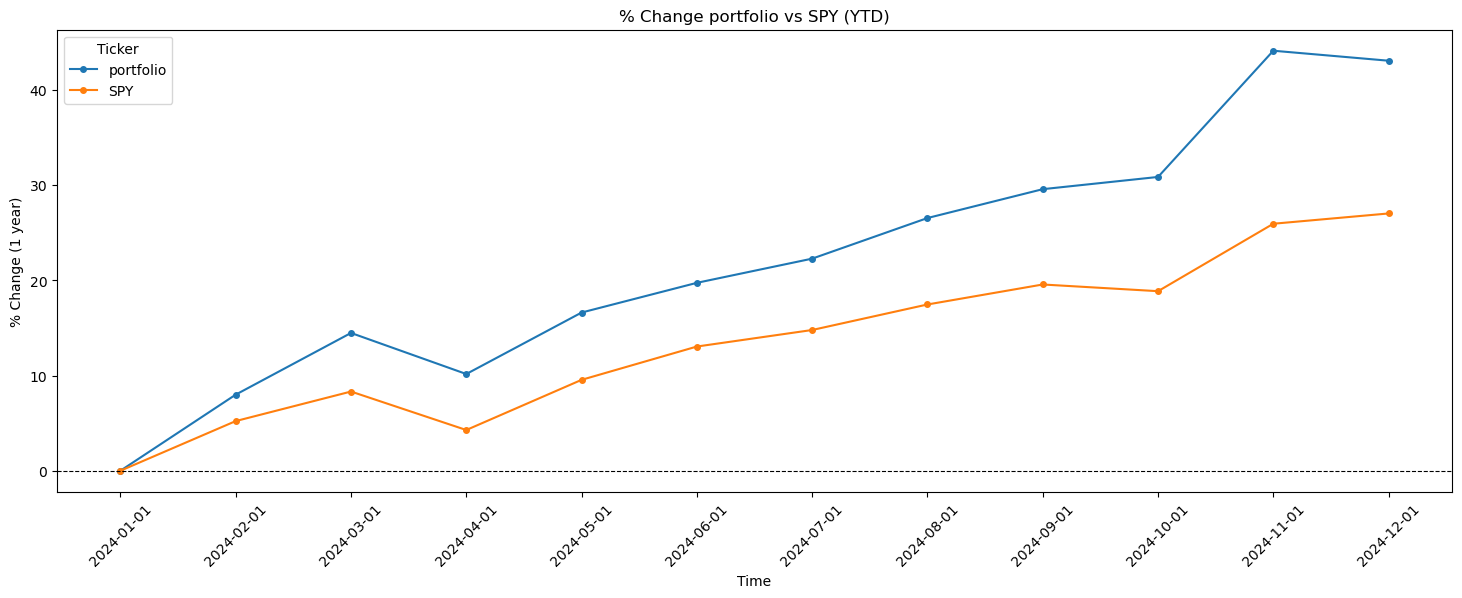

In [103]:
df_avgs = df_avgs.fillna(0)

plt.figure(figsize=(18, 6))
for ticker in df_avgs.index:
    # Select the data from the 3rd column onward
    plt.plot(
        df_avgs.columns[:-2],
        df_avgs.loc[ticker].values[:-2],
        label=ticker,
        marker="o",
        markersize=4,
    )
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.8)
plt.legend(title="Ticker")
plt.xlabel("Time")
plt.ylabel("% Change (1 year)")
plt.title("% Change portfolio vs SPY (YTD)")
plt.xticks(rotation=45)
plt.show()

In [107]:
a = df_avgs
df_avgs

,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,Company Name,Capped_weight
portfolio,0.0,7.998312,14.480697,10.163700,16.625609,19.748890,22.291656,26.559068,29.592693,30.877281,44.144350,43.093828,0.0,0.0
SPY,0.0,5.218691,8.322977,4.278428,9.552792,13.053119,14.791228,17.473382,19.574102,18.870577,25.959242,27.039994,0.0,0.0
